In [96]:
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter
from prophet import Prophet
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [97]:
path = kagglehub.dataset_download("chirag19/air-passengers")

csv_file_path = os.path.join(path, 'AirPassengers.csv')

#Prophet

In [98]:
df = pd.read_csv(csv_file_path)

In [99]:
df.rename(columns = {'#Passengers':'AirPassengers'}, inplace = True)

In [100]:
df['Month'] = pd.DatetimeIndex(df['Month'])
df.dtypes

,0
Month,datetime64[ns]
AirPassengers,int64


In [101]:
df = df.rename(columns={'Month': 'ds',
                        'AirPassengers': 'y'})

df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


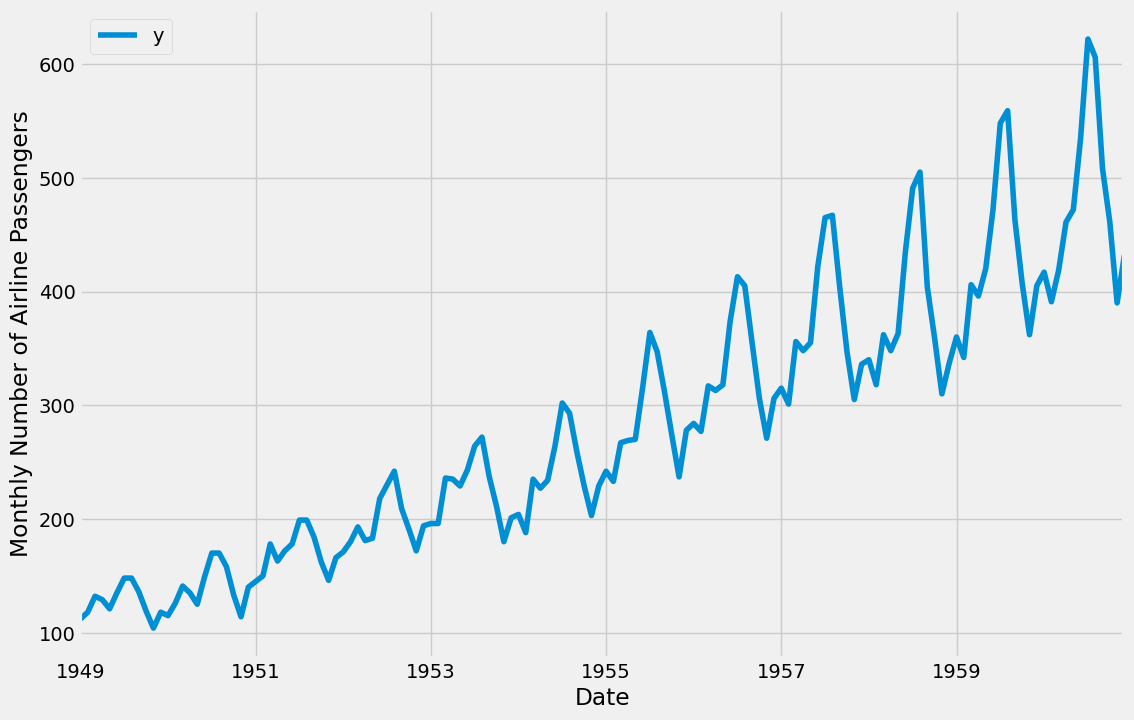

In [102]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

In [103]:
my_model = Prophet(interval_width=0.95)

In [104]:
my_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6cei_dql/qq6inuo2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6cei_dql/_ohmpjps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28811', 'data', 'file=/tmp/tmp6cei_dql/qq6inuo2.json', 'init=/tmp/tmp6cei_dql/_ohmpjps.json', 'output', 'file=/tmp/tmp6cei_dql/prophet_modelhk7eso6g/prophet_model-20250331003645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:36:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [105]:
future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
future_dates.head()

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01


In [106]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


,ds,yhat,yhat_lower,yhat_upper
0,1949-01-01,86.018883,45.477844,130.203120
1,1949-02-01,79.495226,33.317242,122.116520
2,1949-03-01,111.025581,67.773280,153.205120
3,1949-04-01,108.719017,62.520873,150.347439
4,1949-05-01,112.095281,67.096865,156.170546


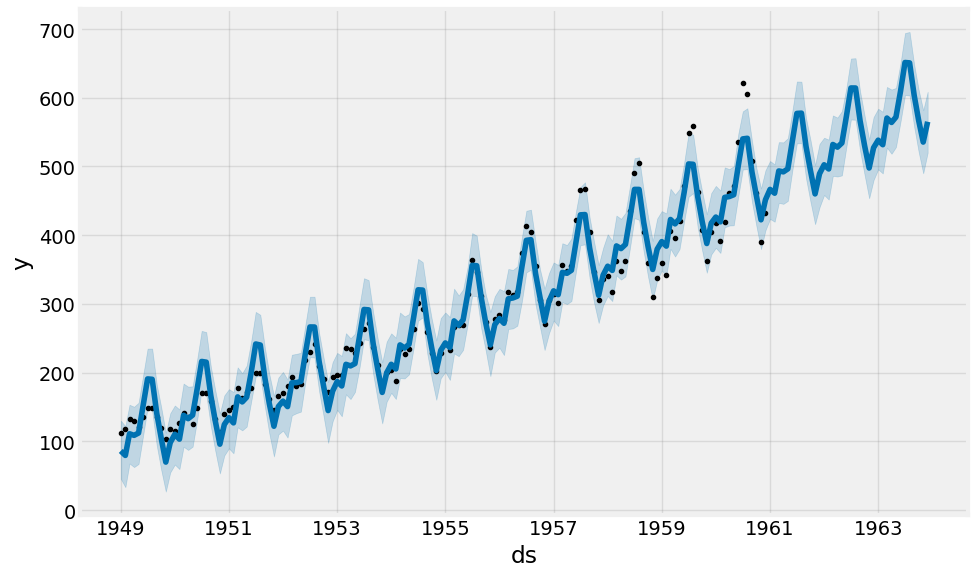

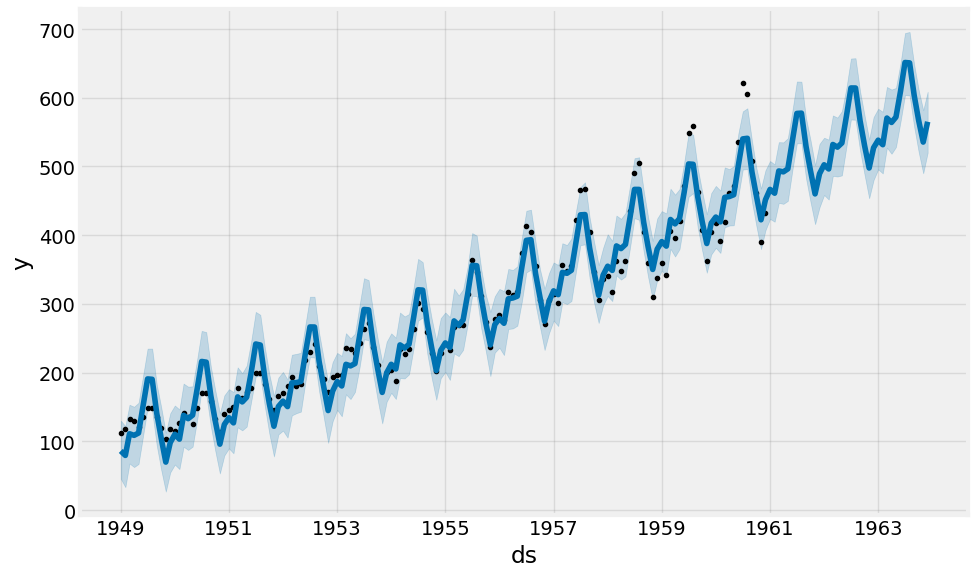

In [107]:
my_model.plot(forecast, uncertainty=True)

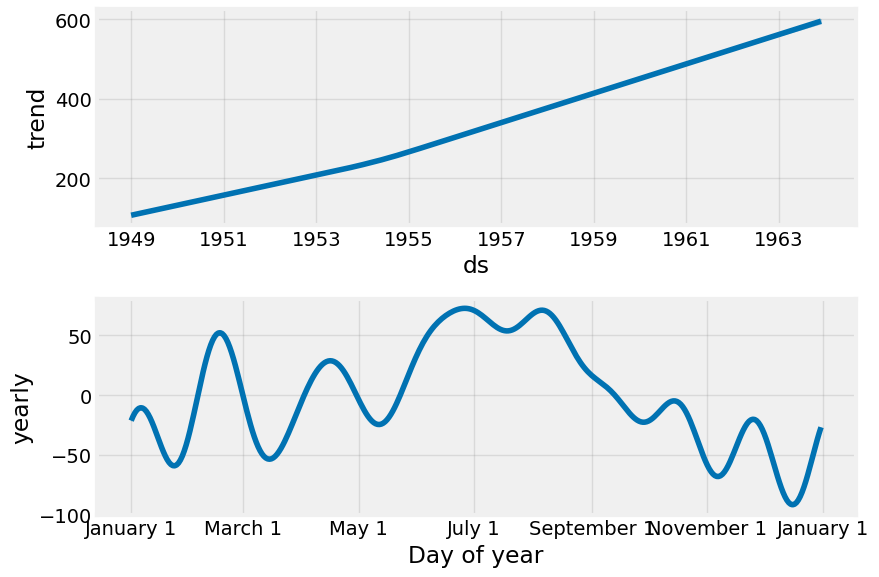

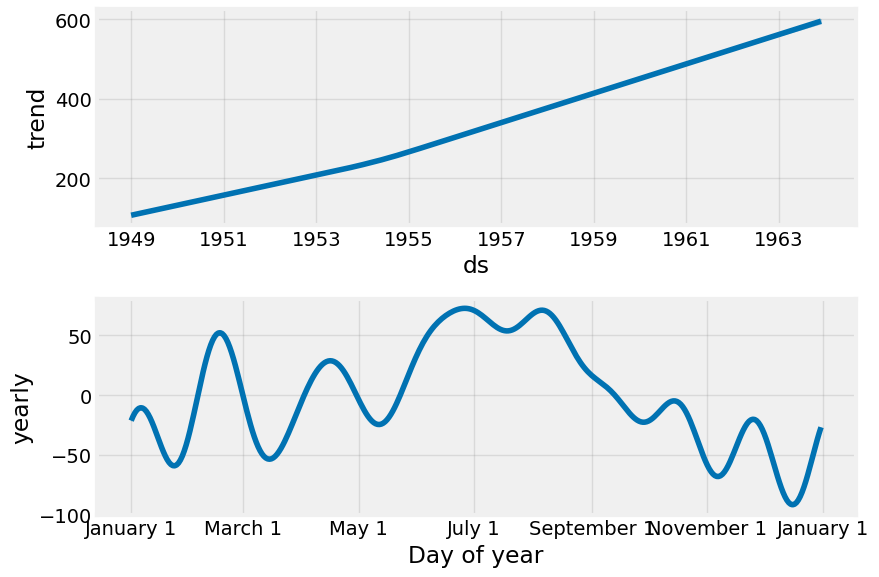

In [108]:
my_model.plot_components(forecast)

In [109]:
forecast_train = forecast[forecast['ds'] <= df['ds'].max()]

# Realizar o merge dos valores reais com as predições
df_merged = pd.merge(df, forecast_train[['ds', 'yhat']], on='ds')

# Cálculo do RMSE
rmse = np.sqrt(mean_squared_error(df_merged['y'], df_merged['yhat']))
print("RMSE:", rmse)

RMSE: 22.430335659922022


#LSTM

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [111]:
# Carregar e preparar os dados
df['data'] = df.ds
df = df.sort_values('data')
dados = df['y'].values.reshape(-1, 1)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
dados_normalizados = scaler.fit_transform(dados)

In [112]:
# Função para criar as sequências de treinamento
def criar_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)


In [113]:

look_back = 10
X, y = criar_dataset(dados_normalizados, look_back)

# Dividir em treino e teste (80/20 é comum)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Redimensionar para formato LSTM
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))


In [114]:
# Definir o modelo LSTM
modelo_lstm = Sequential()
modelo_lstm.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
modelo_lstm.add(LSTM(50))
modelo_lstm.add(Dense(1))
modelo_lstm.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [115]:

historico = modelo_lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Fazer previsões no conjunto de teste
test_predict = modelo_lstm.predict(X_test)

# Desnormalizar as previsões e valores reais
test_predict_inv = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1062
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0498
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0146
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0200
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0149
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0107
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0130
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0107
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0084
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0099
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0092
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0086
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0094
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0077
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0079
Epoch 16/100
4/4 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


In [118]:
y_test_inv

array([[359.],
       [310.],
       [337.],
       [360.],
       [342.],
       [406.],
       [396.],
       [420.],
       [472.],
       [548.],
       [559.],
       [463.],
       [407.],
       [362.],
       [405.],
       [417.],
       [391.],
       [419.],
       [461.],
       [472.],
       [535.],
       [622.],
       [606.],
       [508.],
       [461.],
       [390.],
       [432.]])

In [119]:
test_predict_inv

array([[394.287  ],
       [381.57715],
       [364.462  ],
       [359.11588],
       [360.19073],
       [360.43967],
       [371.5968 ],
       [375.9259 ],
       [378.85718],
       [386.38992],
       [407.9624 ],
       [427.35986],
       [424.90533],
       [410.96924],
       [393.51068],
       [391.8732 ],
       [394.10855],
       [393.1026 ],
       [397.45404],
       [406.83823],
       [411.9211 ],
       [423.4716 ],
       [448.70917],
       [463.8929 ],
       [455.19217],
       [438.52194],
       [415.3053 ]], dtype=float32)

RMSE: 78.71775844596665


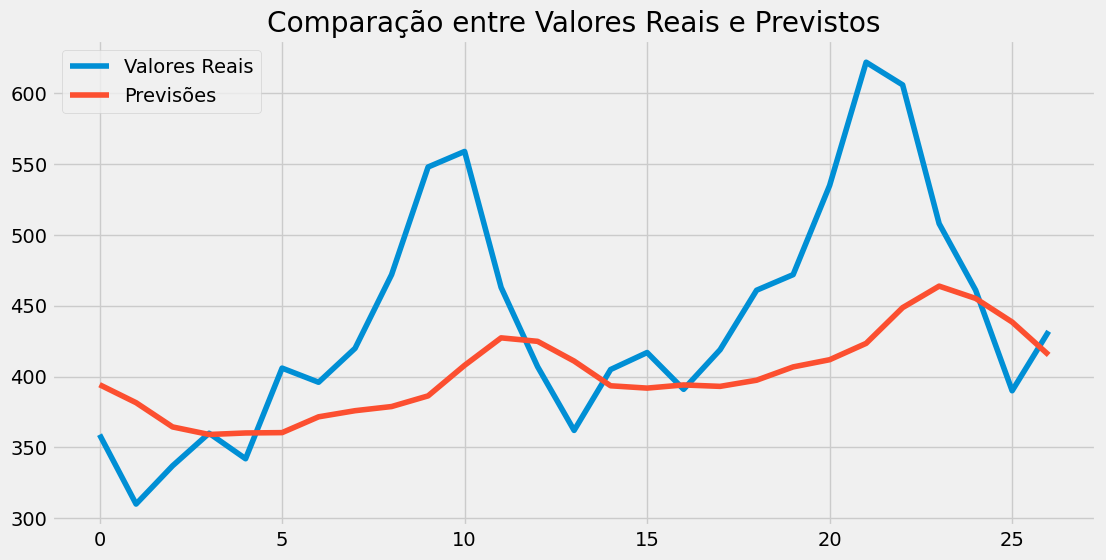

In [116]:
# Calcular RMSE com dados desnormalizados
rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
print("RMSE:", rmse)

# Visualização
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Valores Reais')
plt.plot(test_predict_inv, label='Previsões')
plt.legend()
plt.title('Comparação entre Valores Reais e Previstos')
plt.show()

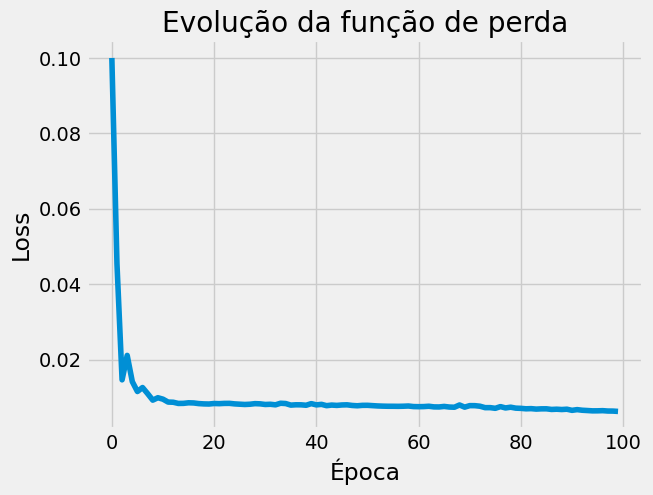

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Próximo valor previsto: 410.76422


In [117]:

# Evolução da função de perda
plt.plot(historico.history['loss'])
plt.title("Evolução da função de perda")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.show()

# Previsão do próximo valor (opcional)
ultimo_valor = dados_normalizados[-look_back:]
ultimo_valor = np.reshape(ultimo_valor, (1, look_back, 1))
prev_normalizada = modelo_lstm.predict(ultimo_valor)
prev = scaler.inverse_transform(prev_normalizada)
print("Próximo valor previsto:", prev[0][0])